In [1]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pyuvdata import UVData

In [2]:
import copy
import time
import hera_sim

/users/jtan/hera_sim/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/jtan/hera_sim/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/jtan/hera_sim/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/jtan/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes 

In [3]:
import polcal

In [4]:
from hera_cal import apply_cal, io

In [5]:
from hera_cal.utils import split_pol, split_bl

### generate gains with hera_sim

In [6]:
hd = io.HERAData("/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/Simulation/zen.2457755.95177.uvCP.uvh5")
data, flags, nsamples = hd.read()

In [7]:
np.random.seed(21)
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())

# generate gains with a realistic bandpass and delays between -20 and 20 ns
true_gains = hera_sim.sigchain.gen_gains(hd.freqs/1e9, ants, dly_rng=(-20, 20))

# add random phase offsets to each antenna's gain
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in true_gains.keys()}

# uncalibratate data and save
true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
              for ant, g in true_gains.items()}
apply_cal.calibrate_in_place(data, true_gains, gain_convention='multiply')
hd.update(data=data)
hd.write_uvh5("/lustre/aoc/projects/hera/jtan/HERA19_test_zen.2457755.95177.uvCP.uvh5", clobber=True)

File exists; clobbering


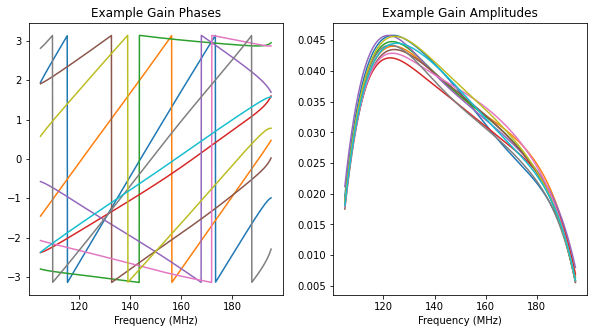

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
for ant in ants[::4]:
    ax[0].plot(hd.freqs[50:-50]/1e6, np.angle(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[0].set_title('Example Gain Phases')
    ax[0].set_xlabel('Frequency (MHz)')
    ax[1].plot(hd.freqs[50:-50]/1e6, np.abs(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[1].set_title('Example Gain Amplitudes')
    ax[1].set_xlabel('Frequency (MHz)')

In [9]:
np.save("true_gains", true_gains)

In [6]:
true_gains = np.load("true_gains.npy",allow_pickle=True).item()

## Apply Smirnov method on single frequency channel

In [7]:
uvd_data, uvd_test = UVData(), UVData() 

In [8]:
uvd_data.read("/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/Simulation/zen.2457755.95177.uvCP.uvh5")

In [9]:
uvd_test.read("/lustre/aoc/projects/hera/jtan/HERA19_test_zen.2457755.95177.uvCP.uvh5")

In [10]:
uv_polcal = polcal.uvdata_pol_calibrator(model_data=uvd_data, real_data=uvd_test, mode="model_based")

In [11]:
uv_polcal.data_slice(use_all_times=True, base_freq_range=[300], prod_freq_range=[300], use_all_ants=True)

### Gauss_Newton method (damping_parameter = 0)

In [12]:
start_time = time.time()
gain_array_iter_GN, residuals_GN = uv_polcal.Wirtinger_lm_cal(diagonalize=True, Niteration=1000,verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 63.392776012420654 seconds ---


### Levenberg_Marquardt method (fixed damping_parameter = 2)

In [13]:
start_time = time.time()
gain_array_iter_LM_fixed, residuals_LM_fixed = uv_polcal.Wirtinger_lm_cal(damping_para=2., diagonalize=True, Niteration=1000,verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.29179620742798 seconds ---


### Levenberg_Marquardt method (updating damping_parameter in each loop)

In [14]:
start_time = time.time()
gain_array_iter_LM_unfixed, residuals_LM_unfixed = uv_polcal.Wirtinger_lm_cal(damping_para=2., update_damping_para_per_loop=True, diagonalize=True, Niteration=1000,verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 62.80368423461914 seconds ---


### residuals vs iterations

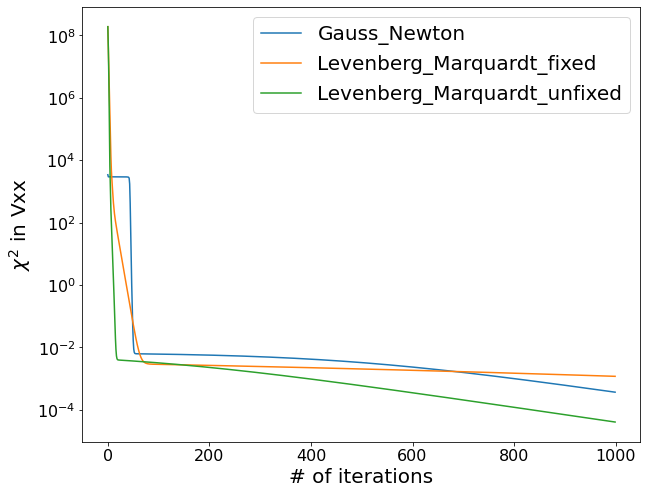

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN[:,0,0], label='Gauss_Newton')
ax.plot(residuals_LM_fixed[:,0,0],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed[:,0,0],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vxx", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

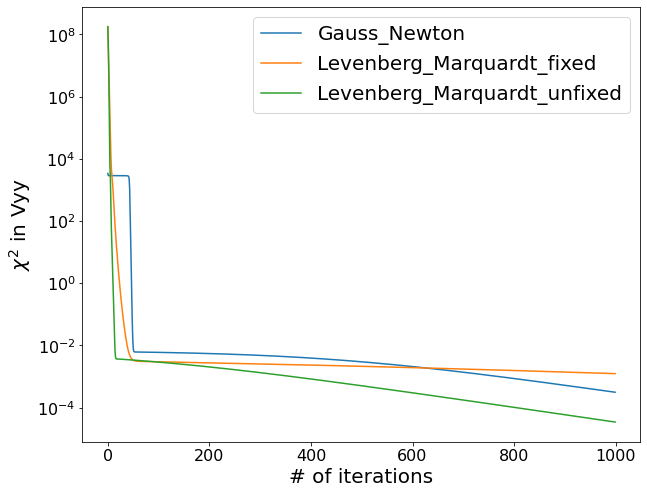

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN[:,1,1], label='Gauss_Newton')
ax.plot(residuals_LM_fixed[:,1,1],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed[:,1,1],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vyy", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

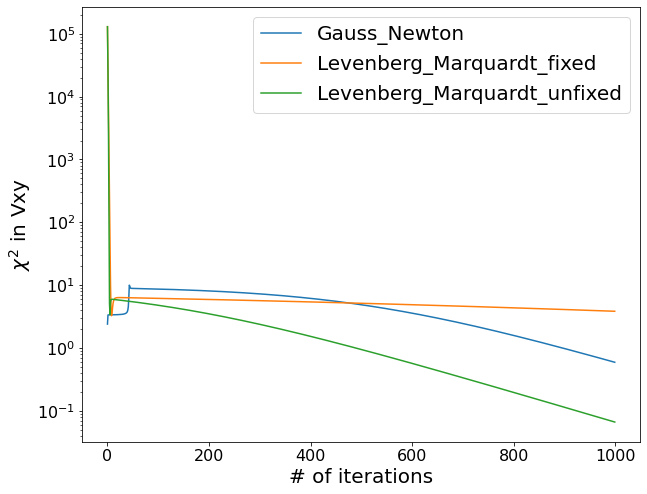

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN[:,0,1], label='Gauss_Newton')
ax.plot(residuals_LM_fixed[:,0,1],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed[:,0,1],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vxy", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

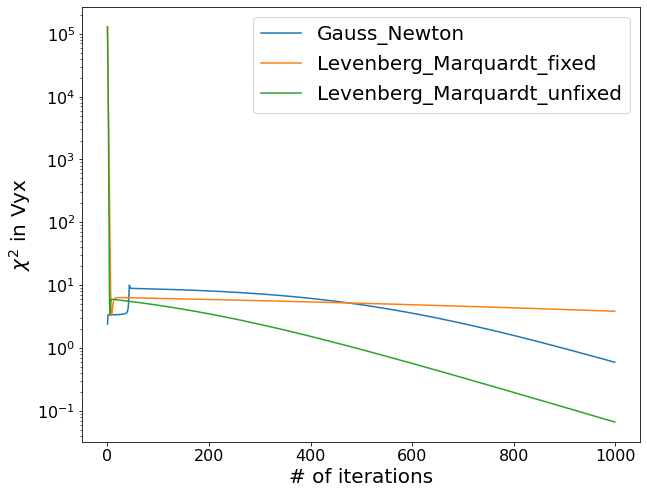

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN[:,1,0], label='Gauss_Newton')
ax.plot(residuals_LM_fixed[:,1,0],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed[:,1,0],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vyx", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

### convergence of recovered gains

In [23]:
true_gain_array = np.zeros(gain_array_iter_LM_fixed.shape[1:]).astype(np.complex128)

In [24]:
ants = np.unique(uvd_data.ant_1_array)

In [25]:
ants_index = {ant: np.argwhere(ants==ant) for ant in ants}

In [26]:
for _key in true_gains.keys():
    ant, pol = _key[0], _key[1]
    if pol == "Jee":
        true_gain_array[ants_index[ant],0,0] = true_gains[_key][0,300]
    if pol == "Jnn":
        true_gain_array[ants_index[ant],1,1] = true_gains[_key][0,300]

Text(0.5, 0, '# of iterations')

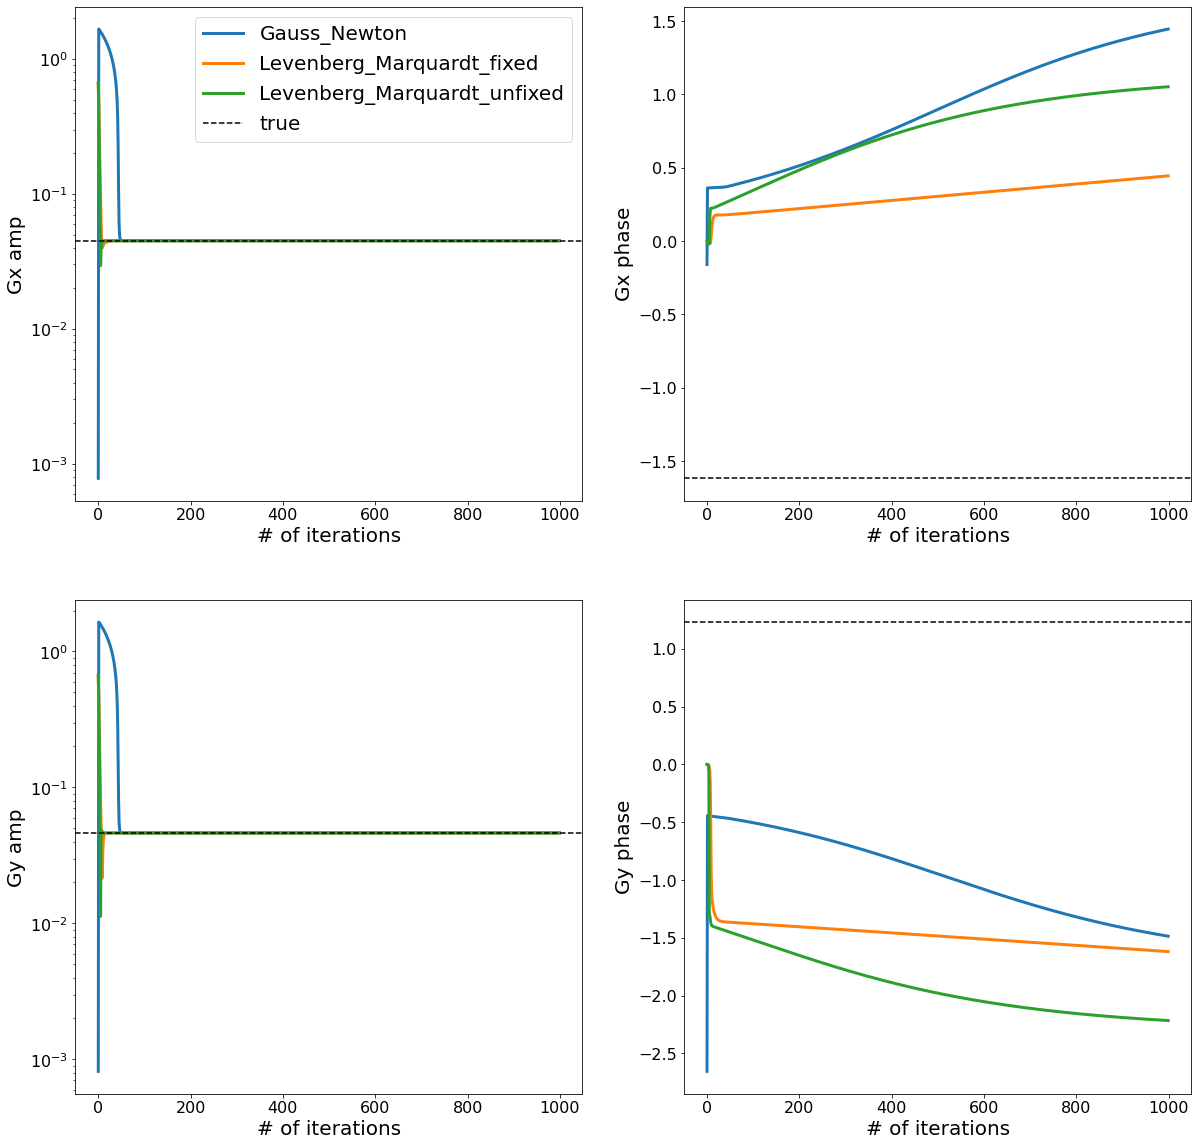

In [27]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter_GN[:,0,0,0]), lw=3, label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed[:,0,0,0]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed[:,0,0,0]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=abs(true_gain_array[0,0,0]), ls="--", lw=1.5, c='k', label='true')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter_GN[:,0,0,0]) , lw=3, label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed[:,0,0,0]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed[:,0,0,0]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=np.angle(true_gain_array[0,0,0]), ls="--", lw=1.5, c='k', label='true')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter_GN[:,0,1,1]), lw=3, label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed[:,0,1,1]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed[:,0,1,1]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=abs(true_gain_array[0,1,1]), ls="--", lw=1.5, c='k', label='true')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter_GN[:,0,1,1]) , lw=3, label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed[:,0,1,1]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed[:,0,1,1]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=np.angle(true_gain_array[0,1,1]), ls="--", lw=1.5, c='k', label='true')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

### compare recovered gains with true gains, up to a constant phase shift

Text(0.5, 0, 'Antenna index')

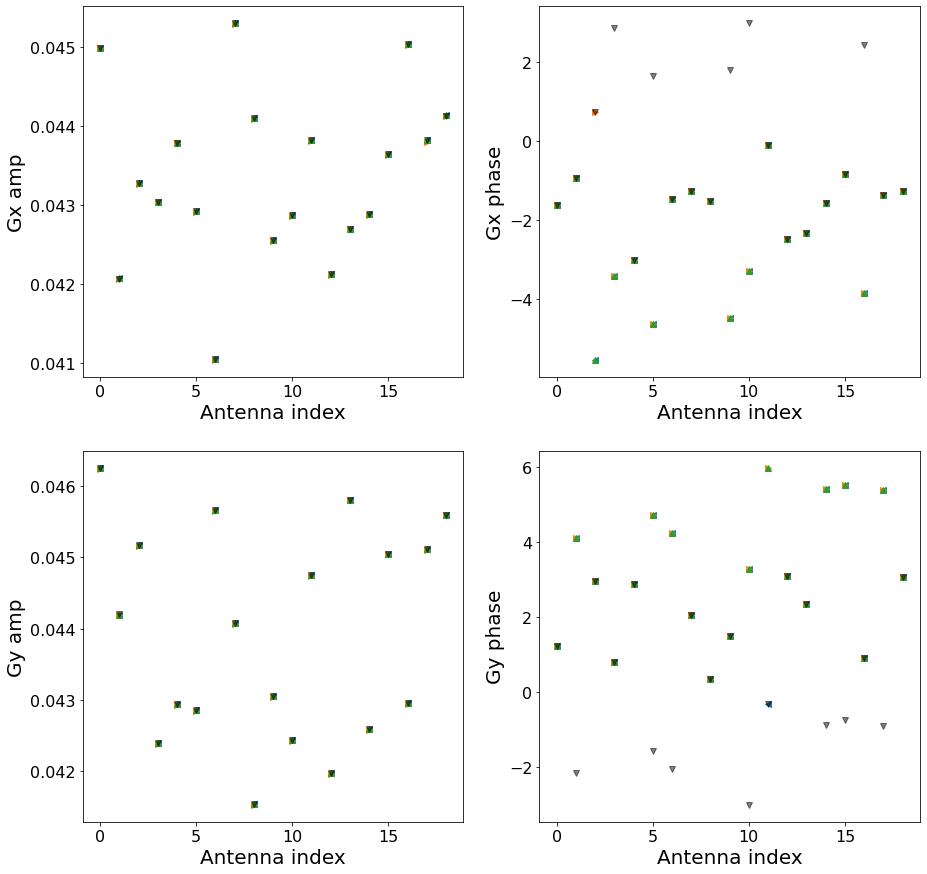

In [28]:
iterations = [10,20,30,40,50]
fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter_GN[-1,:,0,0]), "<",  label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed[-1,:,0,0]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed[-1,:,0,0]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(abs(true_gain_array[:,0,0]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx amp", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter_GN[-1,:,0,0]) + np.angle(true_gain_array[0,0,0]) - np.angle(gain_array_iter_GN[-1,0,0,0]), "<",  label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed[-1,:,0,0]) + np.angle(true_gain_array[0,0,0]) - np.angle(gain_array_iter_LM_fixed[-1,0,0,0]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed[-1,:,0,0]) + np.angle(true_gain_array[0,0,0]) - np.angle(gain_array_iter_LM_unfixed[-1,0,0,0]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(np.angle(true_gain_array[:,0,0]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx phase", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter_GN[-1,:,1,1]), "<",  label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed[-1,:,1,1]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed[-1,:,1,1]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(abs(true_gain_array[:,1,1]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy amp", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter_GN[-1,:,1,1]) + np.angle(true_gain_array[0,1,1]) - np.angle(gain_array_iter_GN[-1,0,1,1]), "<",  label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed[-1,:,1,1]) + np.angle(true_gain_array[0,1,1]) - np.angle(gain_array_iter_LM_fixed[-1,0,1,1]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed[-1,:,1,1]) + np.angle(true_gain_array[0,1,1]) - np.angle(gain_array_iter_LM_unfixed[-1,0,1,1]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(np.angle(true_gain_array[:,1,1]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy phase", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

# What if we don't set constraints on diagonality?

### Gauss_Newton method (damping_parameter = 0)

In [29]:
start_time = time.time()
gain_array_iter_GN_nd, residuals_GN_nd = uv_polcal.Wirtinger_lm_cal(Niteration=1000,verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 63.501174211502075 seconds ---


### Levenberg_Marquardt method (fixed damping_parameter = 2)

In [30]:
start_time = time.time()
gain_array_iter_LM_fixed_nd, residuals_LM_fixed_nd = uv_polcal.Wirtinger_lm_cal(damping_para=2., Niteration=1000,verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 65.31578707695007 seconds ---


### Levenberg_Marquardt method (updating damping_parameter in each loop)

In [31]:
start_time = time.time()
gain_array_iter_LM_unfixed_nd, residuals_LM_unfixed_nd = uv_polcal.Wirtinger_lm_cal(damping_para=2., update_damping_para_per_loop=True, Niteration=1000,verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 63.23482322692871 seconds ---


### residuals vs iterations

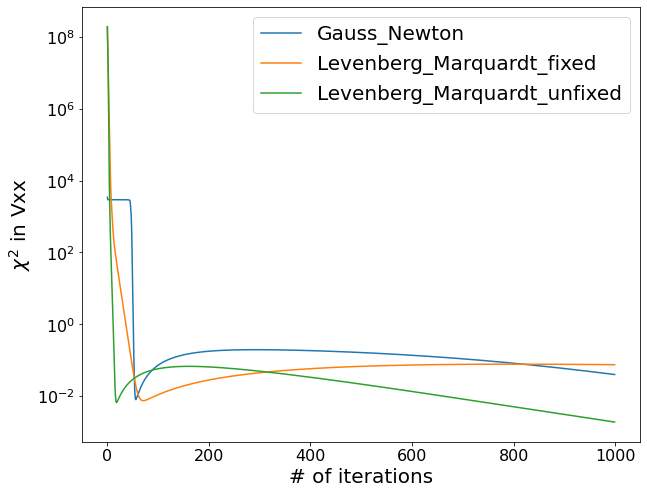

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN_nd[:,0,0], label='Gauss_Newton')
ax.plot(residuals_LM_fixed_nd[:,0,0],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed_nd[:,0,0],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vxx", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

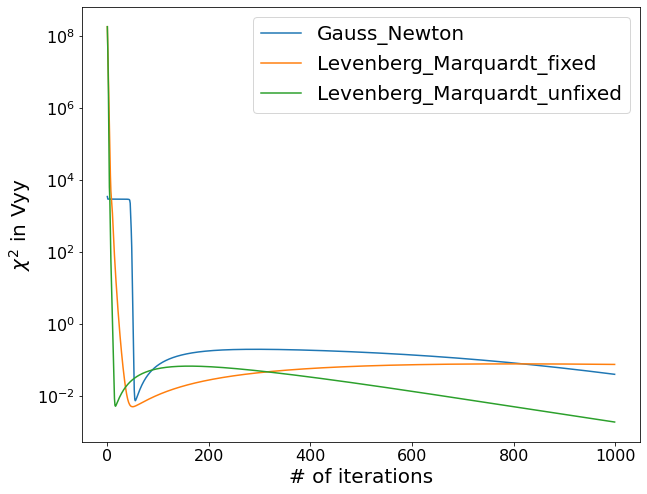

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN_nd[:,1,1], label='Gauss_Newton')
ax.plot(residuals_LM_fixed_nd[:,1,1],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed_nd[:,1,1],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vyy", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

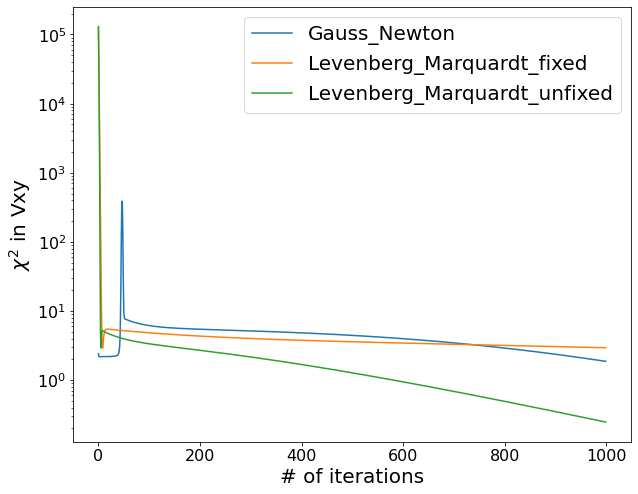

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN_nd[:,0,1], label='Gauss_Newton')
ax.plot(residuals_LM_fixed_nd[:,0,1],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed_nd[:,0,1],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vxy", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

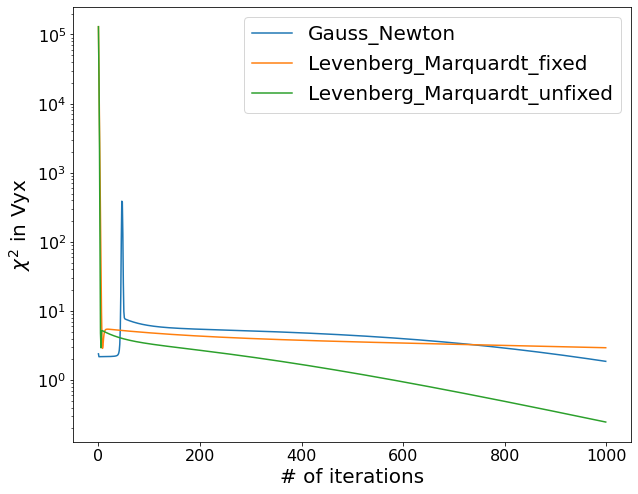

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals_GN_nd[:,1,0], label='Gauss_Newton')
ax.plot(residuals_LM_fixed_nd[:,1,0],label='Levenberg_Marquardt_fixed')
ax.plot(residuals_LM_unfixed_nd[:,1,0],label='Levenberg_Marquardt_unfixed')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$ in Vyx", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

### convergence of recovered gains

Text(0.5, 0, '# of iterations')

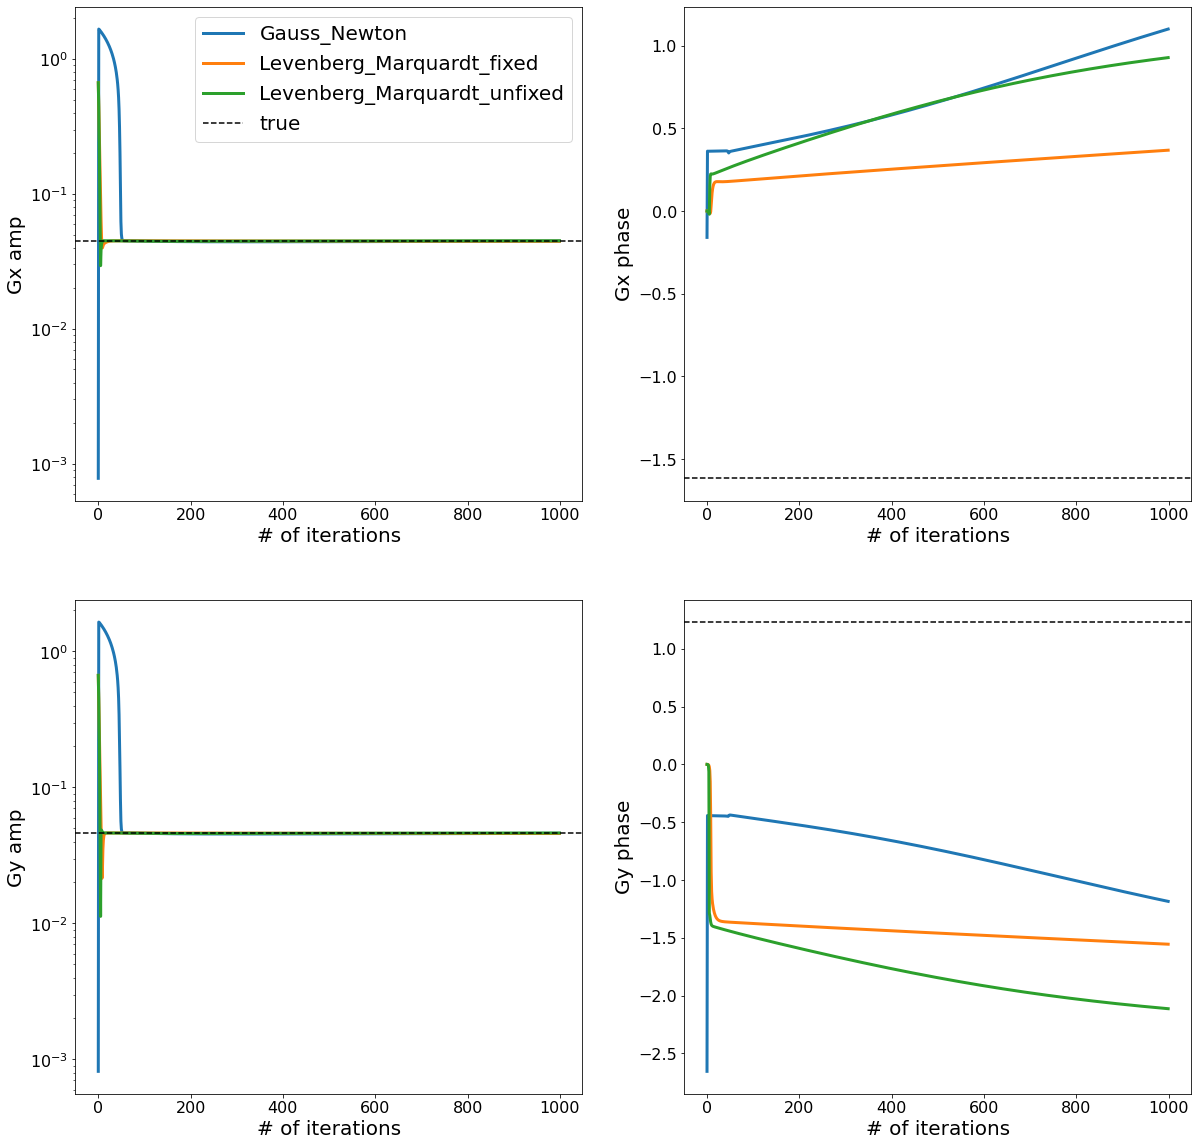

In [36]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter_GN_nd[:,0,0,0]), lw=3, label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[:,0,0,0]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[:,0,0,0]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=abs(true_gain_array[0,0,0]), ls="--", lw=1.5, c='k', label='true')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter_GN_nd[:,0,0,0]) , lw=3, label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[:,0,0,0]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[:,0,0,0]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=np.angle(true_gain_array[0,0,0]), ls="--", lw=1.5, c='k', label='true')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter_GN_nd[:,0,1,1]), lw=3, label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[:,0,1,1]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[:,0,1,1]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=abs(true_gain_array[0,1,1]), ls="--", lw=1.5, c='k', label='true')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter_GN_nd[:,0,1,1]) , lw=3, label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[:,0,1,1]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[:,0,1,1]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=np.angle(true_gain_array[0,1,1]), ls="--", lw=1.5, c='k', label='true')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

Text(0.5, 0, '# of iterations')

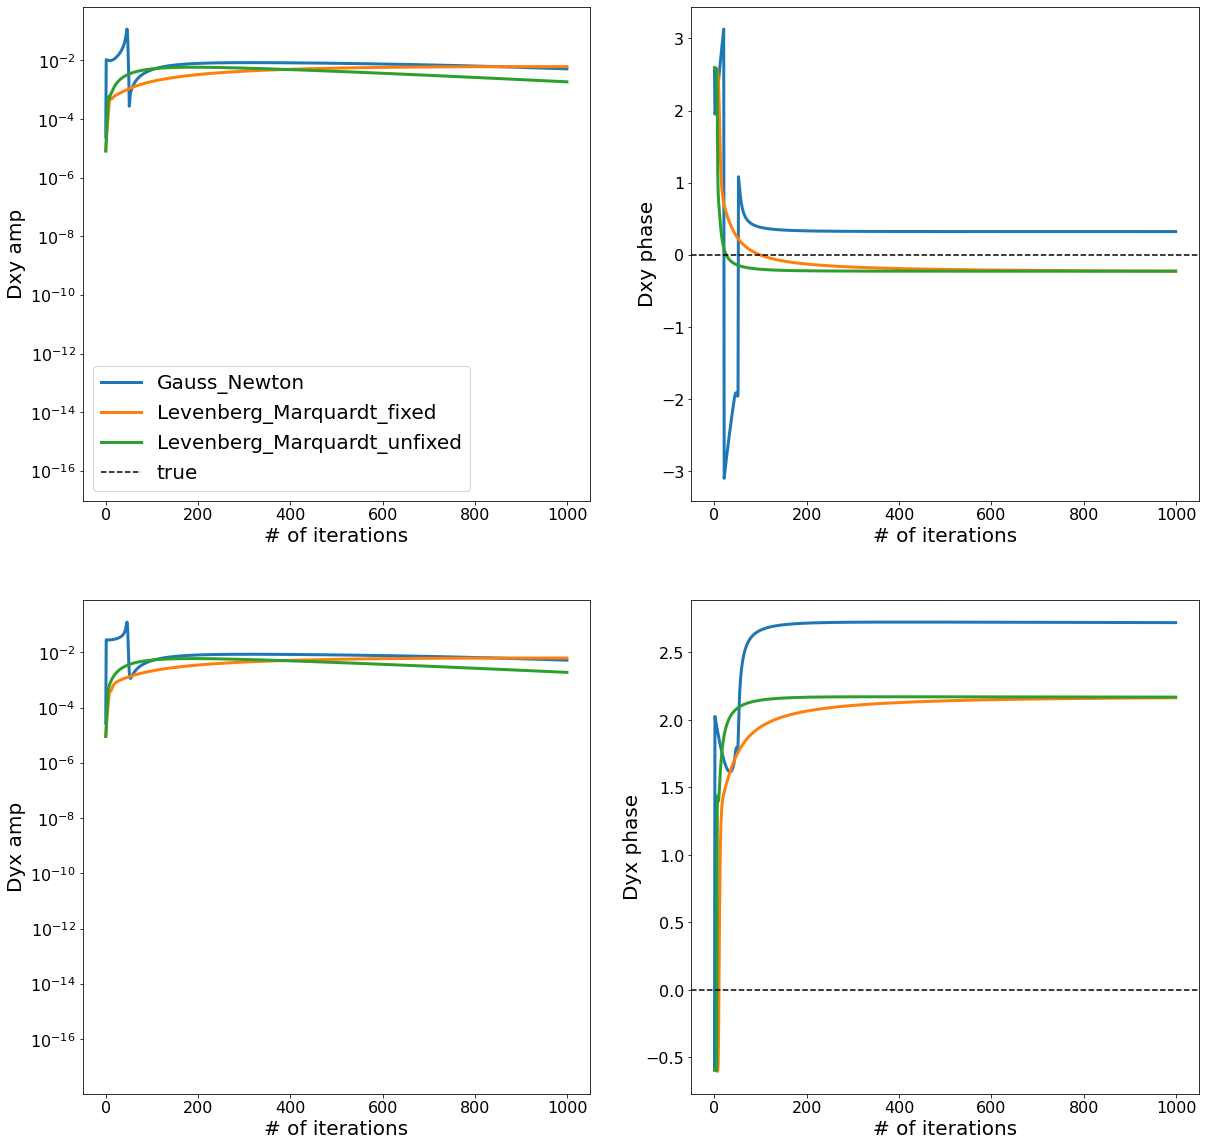

In [37]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter_GN_nd[:,0,0,1]), lw=3, label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[:,0,0,1]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[:,0,0,1]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=abs(true_gain_array[0,0,1]), ls="--", lw=1.5, c='k', label='true')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dxy amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter_GN_nd[:,0,0,1]) , lw=3, label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[:,0,0,1]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[:,0,0,1]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=np.angle(true_gain_array[0,0,1]), ls="--", lw=1.5, c='k', label='true')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dxy phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter_GN_nd[:,0,1,0]), lw=3, label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[:,0,1,0]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[:,0,1,0]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=abs(true_gain_array[0,1,0]), ls="--", lw=1.5, c='k', label='true')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dyx amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter_GN_nd[:,0,1,0]) , lw=3, label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[:,0,1,0]), lw=3, label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[:,0,1,0]), lw=3, label='Levenberg_Marquardt_unfixed')
ax.axhline(y=np.angle(true_gain_array[0,1,0]), ls="--", lw=1.5, c='k', label='true')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dyx phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

### compare recovered gains with true gains, up to a constant phase shift

Text(0.5, 0, 'Antenna index')

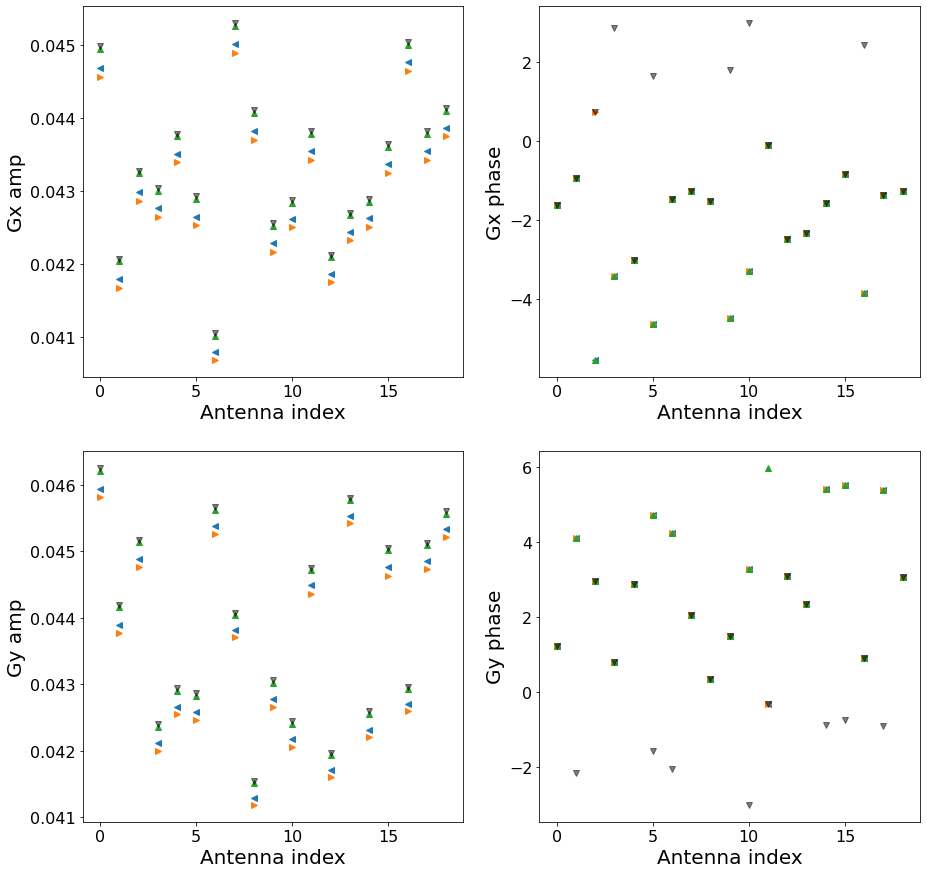

In [38]:
iterations = [10,20,30,40,50]
fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter_GN_nd[-1,:,0,0]), "<",  label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[-1,:,0,0]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[-1,:,0,0]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(abs(true_gain_array[:,0,0]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx amp", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter_GN_nd[-1,:,0,0]) + np.angle(true_gain_array[0,0,0]) - np.angle(gain_array_iter_GN_nd[-1,0,0,0]), "<",  label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[-1,:,0,0]) + np.angle(true_gain_array[0,0,0]) - np.angle(gain_array_iter_LM_fixed_nd[-1,0,0,0]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[-1,:,0,0]) + np.angle(true_gain_array[0,0,0]) - np.angle(gain_array_iter_LM_unfixed_nd[-1,0,0,0]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(np.angle(true_gain_array[:,0,0]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gx phase", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter_GN_nd[-1,:,1,1]), "<",  label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[-1,:,1,1]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[-1,:,1,1]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(abs(true_gain_array[:,1,1]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy amp", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter_GN_nd[-1,:,1,1]) + np.angle(true_gain_array[0,1,1]) - np.angle(gain_array_iter_GN_nd[-1,0,1,1]), "<",  label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[-1,:,1,1]) + np.angle(true_gain_array[0,1,1]) - np.angle(gain_array_iter_LM_fixed_nd[-1,0,1,1]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[-1,:,1,1]) + np.angle(true_gain_array[0,1,1]) - np.angle(gain_array_iter_LM_unfixed_nd[-1,0,1,1]), "^", label='Levenberg_Marquardt_unfixed')
ax.plot(np.angle(true_gain_array[:,1,1]),"v", label='true', c='k', alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Gy phase", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

Text(0.5, 0, 'Antenna index')

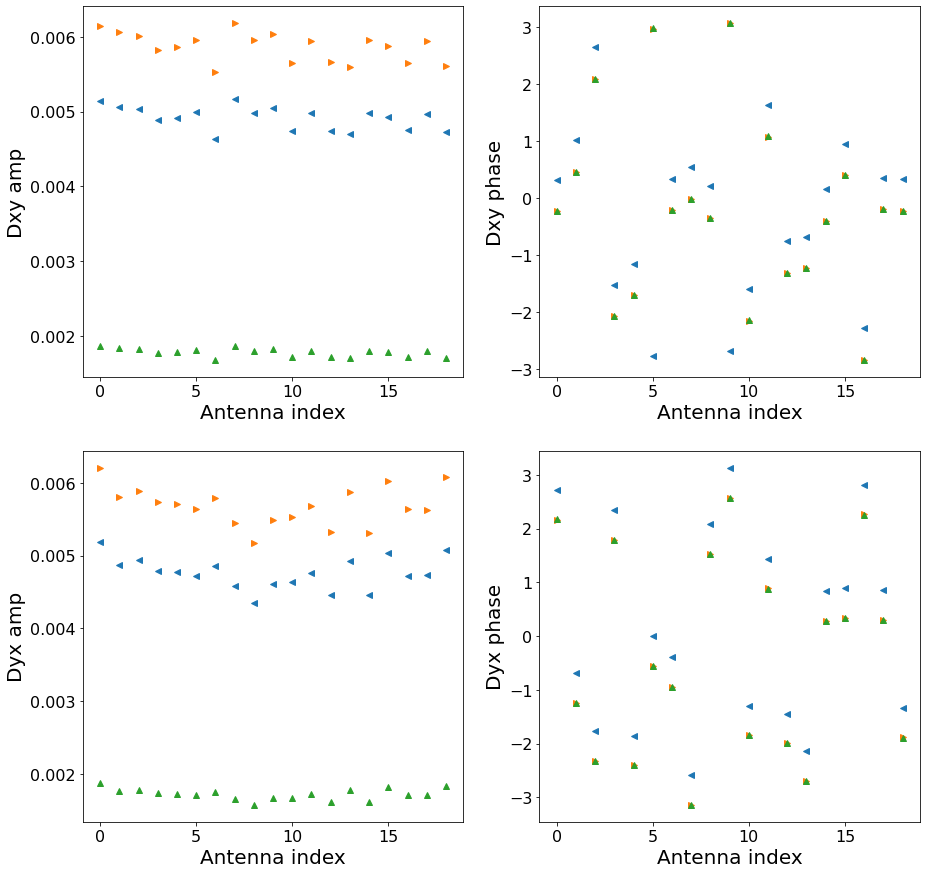

In [39]:
iterations = [10,20,30,40,50]
fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter_GN_nd[-1,:,0,1]), "<",  label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[-1,:,0,1]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[-1,:,0,1]), "^", label='Levenberg_Marquardt_unfixed')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dxy amp", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter_GN_nd[-1,:,0,1]), "<",  label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[-1,:,0,1]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[-1,:,0,1]), "^", label='Levenberg_Marquardt_unfixed')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dxy phase", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter_GN_nd[-1,:,1,0]), "<",  label='Gauss_Newton')
ax.plot(abs(gain_array_iter_LM_fixed_nd[-1,:,1,0]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(abs(gain_array_iter_LM_unfixed_nd[-1,:,1,0]), "^", label='Levenberg_Marquardt_unfixed')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dyx amp", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter_GN_nd[-1,:,1,0]), "<",  label='Gauss_Newton')
ax.plot(np.angle(gain_array_iter_LM_fixed_nd[-1,:,1,0]), ">",  label='Levenberg_Marquardt_fixed')
ax.plot(np.angle(gain_array_iter_LM_unfixed_nd[-1,:,1,0]), "^", label='Levenberg_Marquardt_unfixed')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("Dyx phase", fontsize=20)
ax.set_xlabel("Antenna index", fontsize=20)